<a href="https://colab.research.google.com/github/PawinData/TM/blob/main/TM_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 3.9MB/s 


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus.reader.conll import ConllCorpusReader
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn_crfsuite import CRF, metrics
from random import seed

# Pre-processing

Build the [reader of dataset](https://www.nltk.org/_modules/nltk/corpus/reader/conll.html) and represent every sentence as a list of tuple (word, POS, OBI).

In [ ]:
# a .ConLL file reader
READER = ConllCorpusReader(root="./", fileids=".conll", columntypes=('words','pos','tree','chunk','ne','srl','ignore'))

In [3]:
def load(filename):
    word_pos = [nltk.pos_tag(sentence) for sentence in READER.sents(filename)]
    word_obi = list(READER.tagged_sents(filename))
    return [[(a,b,d) for (a,b),(c,d) in zip(lst1, lst2)] for lst1,lst2 in zip(word_pos,word_obi)]

# training set
Train_sents = load("wnut17train.conll")
# test set
Test_sents = load("emerging.test.annotated")

In [4]:
# Development set
word_pos = [nltk.pos_tag(sentence) for sentence in READER.sents("emerging.dev.conll")[:1008]]
word_obi = list(READER.tagged_sents("emerging.dev.conll")[:1008])
Dev_sents = [[(a,b,d) for (a,b),(c,d) in zip(lst1, lst2)] for lst1,lst2 in zip(word_pos,word_obi)]

# EDA

In [6]:
# words/sentences count
print("There are", len(Train_sents), "sentences and", sum([len(s) for s in Train_sents]), "words in the training set.")
print("There are", len(Dev_sents), "sentences and", sum([len(s) for s in Dev_sents]), "words in the development set.")
print("There are", len(Test_sents), "sentences and", sum([len(s) for s in Test_sents]), "words in the test set.")

There are 3394 sentences and 62730 words in the training set.
There are 1008 sentences and 15723 words in the development set.
There are 1287 sentences and 23394 words in the test set.


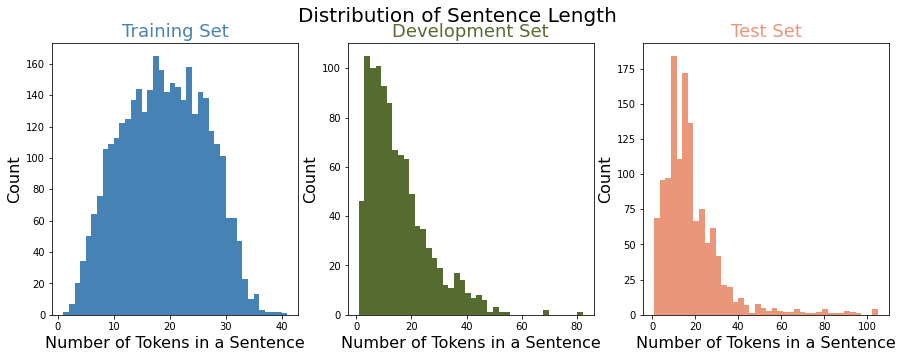

In [8]:
# distribution of sentence length
fig, axs = plt.subplots(1,3, figsize=(20,5))
fig.suptitle("Distribution of Sentence Length", fontsize=20)
for i,(S,C,T) in enumerate(zip([Train_sents,Dev_sents,Test_sents],
                               ["steelblue","darkolivegreen","darksalmon"],
                               ["Training Set","Development Set","Test Set"])):
    axs[i].hist([len(s) for s in S], bins=40, color=C)
    axs[i].set_title(T, fontsize=18, color=C)
    axs[i].set_xlabel("Number of Tokens in a Sentence", fontsize=16)
    axs[i].set_ylabel("Count", fontsize=16)
plt.show()

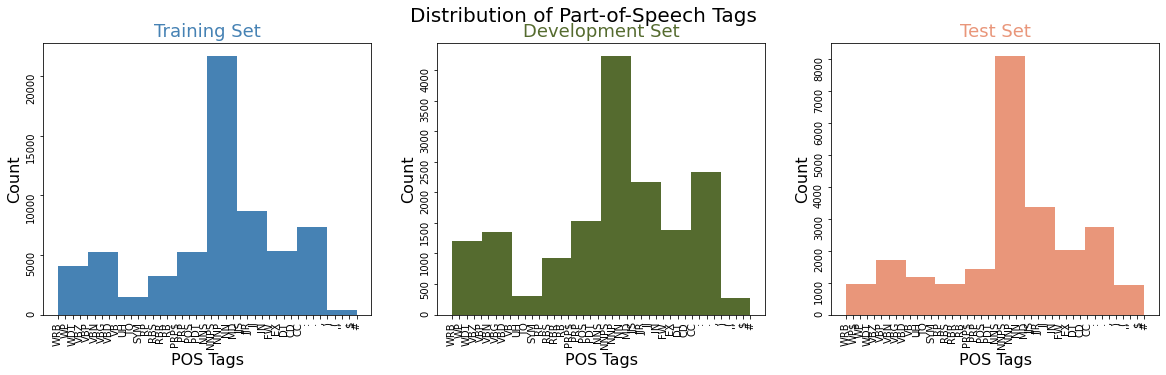

In [7]:
# distribution of POS tags
def extract_POS(filename):
    word_pos = [nltk.pos_tag(sentence) for sentence in READER.sents(filename)]
    pos = list()
    for sentence in word_pos:
        pos.extend([b for a,b in sentence])
    return pos

Train_pos = extract_POS("wnut17train.conll")  # training set
Test_pos = extract_POS("emerging.test.annotated")  # test set
word_pos = [nltk.pos_tag(sentence) for sentence in READER.sents("emerging.dev.conll")[:1008]]
Dev_pos = list()
for sentence in word_pos:
    Dev_pos.extend([b for a,b in sentence])    # dev set

Train_pos.sort(reverse=True)  # training set
Dev_pos.sort(reverse=True)    # test set
Test_pos.sort(reverse=True)   # dev set

fg, ax = plt.subplots(1,3, figsize=(20,5))
fg.suptitle("Distribution of Part-of-Speech Tags", fontsize=20)
for i,(S,C,T) in enumerate(zip([Train_pos,Dev_pos,Test_pos],
                               ["steelblue","darkolivegreen","darksalmon"],
                               ["Training Set","Development Set","Test Set"])):
    ax[i].hist(S, color=C)
    ax[i].set_title(T, fontsize=18, color=C)
    ax[i].set_xlabel("POS Tags", fontsize=16)
    ax[i].set_ylabel("Count", fontsize=16)
    ax[i].tick_params(labelrotation=90)
plt.show()

In the training set,
94.96% tokens are labelled with the O-Tag.

In the development set,
92.06% tokens are labelled with the O-Tag.

In the test set,
92.56% tokens are labelled with the O-Tag.



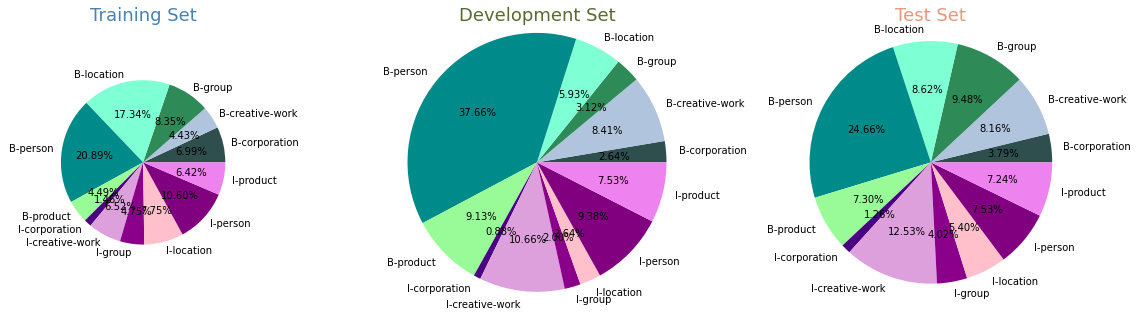

In [46]:
# proportion of O-tags
def prop_O(data_sents):
    count_O = sum([np.sum(np.array([c for a,b,c in sentence])=="O") for sentence in data_sents])
    count_all = sum([len(sentence) for sentence in data_sents])
    print("{:.2%} tokens are labelled with the O-Tag.\n".format(count_O/count_all))

print("In the training set,")
prop_O(Train_sents)
print("In the development set,")
prop_O(Dev_sents)
print("In the test set,")
prop_O(Test_sents)

# distribution of B-Tag and I-Tag
def count_BI(data_sents):   
    lst = list()
    for sentence in data_sents:
        lst.extend([c for a,b,c in sentence])
    Tags = list(set((lst)))
    Tags.remove("O")
    Tags.sort()
    lst = np.array(lst)
    COUNT = dict()
    for tag in Tags:
        COUNT[tag] = np.sum(lst==tag)
    return COUNT

CLR = ['darkslategray','lightsteelblue','seagreen','aquamarine','darkcyan','palegreen',
       'indigo','plum','darkmagenta','pink','purple','violet']
pic,axes = plt.subplots(1,3, figsize=(20,5))
#pic.suptitle("Distribution of B-Tag and I-Tag", fontsize=20)
for i,(S,C,T,r) in enumerate(zip([Train_sents,Dev_sents,Test_sents],
                                 ["Steelblue","darkolivegreen","darksalmon"],
                                 ["Training Set","Development Set","Test Set"],
                                 [0.9496, 0.9206, 0.9256])):
    data = count_BI(S)
    axes[i].pie(list(data.values()), labels=tuple(data.keys()), 
                autopct='%1.2f%%', colors=CLR, radius=15*(1-r))
    axes[i].set_title(T, fontsize=18, color=C)
    #axes[i].axis('equal')
plt.show()

# Baseline

Extract the OBI label and the following features from each word in a sentence. Build a model of Conditional Random Field (**CRF**) on the training data and evaluate its performance on the test set. As a baseline, generate **transition features** that associate all of possible label pairs and **iterate $100$ times at most** by the **L-BFGS algorithm of Gradient Descent** with Elastic-Net regularization to fit model parameters; in specific, **L1-regularization** is controlled by $c_1 = 0.1$ and **L2-regularization** by $c_2 = 0.1$.

**Features:**
1.   **Word Identity**: lowercased form
2.   **Word Suffix**: the last two and three characters
3.   **Word Shape**: whether a word is a digit, is uppercased, or starts with an uppercase character
4.   **Part-of-Speech Tag**: noun, verb, adjective, e.t.c
5.   **BOS**: whether a word is the start of sentence
6.   **EOS**: whether a word is the end of sentence



In [10]:
# extract features and labels
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {'bias': 1.0,
                'word.lower()': word.lower(),        # word identity
                'word[-3:]': word[-3:],              # word suffix 
                'word[-2:]': word[-2:],
                'word.isupper()': word.isupper(),    # word shape
                'word.istitle()': word.istitle(),
                'word.isdigit()': word.isdigit(),
                'postag': postag,                    # POS tag
                'postag[:2]': postag[:2],
               }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({'-1:word.lower()': word1.lower(),
                          '-1:word.istitle()': word1.istitle(),
                          '-1:word.isupper()': word1.isupper(),
                          '-1:postag': postag1,
                          '-1:postag[:2]': postag1[:2],
                      })
    else:
        features['BOS'] = True                      # BOS

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({'+1:word.lower()': word1.lower(),
                         '+1:word.istitle()': word1.istitle(),
                         '+1:word.isupper()': word1.isupper(),
                         '+1:postag': postag1,
                         '+1:postag[:2]': postag1[:2],
                       })
    else:
        features['EOS'] = True                     # EOS

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def setup(data_sents):
    return [sent2features(s) for s in data_sents], [sent2labels(s) for s in data_sents]

In [11]:
# set up datasets
X_train,y_train = setup(Train_sents)
X_test, y_test  = setup(Test_sents)
X_dev,  y_dev   = setup(Dev_sents)

In [ ]:
# training
baseline = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
baseline.fit(X_train, y_train)

In [13]:
# evaluate
print("Overall Accuracy on Test Set:", baseline.score(X_test, y_test), "\n")

labels = list(baseline.classes_)
labels.remove('O')
sorted_labels = sorted(labels, key = lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(y_test, baseline.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.9286141745746773 

                 precision    recall  f1-score   support

  B-corporation     0.0000    0.0000    0.0000        66
  I-corporation     0.0000    0.0000    0.0000        22
B-creative-work     0.3333    0.0352    0.0637       142
I-creative-work     0.2963    0.0367    0.0653       218
        B-group     0.3000    0.0364    0.0649       165
        I-group     0.3571    0.0714    0.1190        70
     B-location     0.3846    0.2333    0.2905       150
     I-location     0.2308    0.0638    0.1000        94
       B-person     0.5514    0.1375    0.2201       429
       I-person     0.5472    0.2214    0.3152       131
      B-product     0.6000    0.0236    0.0455       127
      I-product     0.3750    0.0476    0.0845       126

      micro avg     0.4297    0.0931    0.1530      1740
      macro avg     0.3313    0.0756    0.1141      1740
   weighted avg     0.4009    0.0931    0.1422      1740



The baseline run performs rather poorly for recognizing **B-tags and I-tags**, although the overall accuracy reaches as high as $93\%$. Recall scores are particularly low.

# Hyperparameters Optimization

Execute a grid search for better algorithm and optimal hyperparameters of the CRF model. Candidate algorithms are **Gradient Descent with L-BFGS method** and **Stochastic Gradient Descent with L2 regularization**. Also, check if generating **transition features** improves the labeling. 

Performance is evaluated by the **F1-score** of B-tags and I-tags on different **evaluation sets**. The optimal hyperparameters are those scoring the highest on the evaluation set.

## Cross-Validation

Randomly split the training set into $K=5$ subsets. In each of the $5$ runs, train the model on $4$ subsets merged and compute the score on the the other subset, then the performance yielded by a specific combination of hyperparameters is evaluated by the average of these $5$ scores.

Execute a random search on $c_1 \sim \exp(-2\nu)$ and $c_2 \sim \exp(-20\nu)$. $50$ independent samples of $(c_1, c_2)$ are generated and tried for model fitting.

In [16]:
# randomm search of (c1, c2, all_possible_transitions) using Gradient Descent with L-BFGS

seed(29)

net = CRF(algorithm='lbfgs', max_iterations=100)
params_space = {'c1': scipy.stats.expon(scale=0.5), 
                'c2': scipy.stats.expon(scale=0.05),
                'all_possible_transitions': [True,False]
               }
rs = RandomizedSearchCV(net, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=make_scorer(metrics.flat_f1_score, average='weighted', labels=labels))
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 61.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=None, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faaebfb07b8>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, l

In [17]:
# optimized results
print("Using Gradient Descent with L-BFGS, \n")
print('Best Parameters:', rs.best_params_)
print('Best CV Score:', rs.best_score_)
print('Model Size: {:0.2f}M'.format(rs.best_estimator_.size_ / 10**6))

Using Gradient Descent with L-BFGS, 

Best Parameters: {'all_possible_transitions': True, 'c1': 0.1506461620793222, 'c2': 0.015507926153636843}
Best CV Score: 0.4209605149935597
Model Size: 0.63M


In [19]:
# evaluate
net = rs.best_estimator_
print("Overall Accuracy on Test Set:", net.score(X_test,y_test))
print(metrics.flat_classification_report(y_test, net.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.9278874925194495
                 precision    recall  f1-score   support

  B-corporation     0.0000    0.0000    0.0000        66
  I-corporation     0.0000    0.0000    0.0000        22
B-creative-work     0.3125    0.0352    0.0633       142
I-creative-work     0.3333    0.0505    0.0876       218
        B-group     0.2083    0.0303    0.0529       165
        I-group     0.2941    0.0714    0.1149        70
     B-location     0.3441    0.2133    0.2634       150
     I-location     0.3214    0.0957    0.1475        94
       B-person     0.6000    0.1259    0.2081       429
       I-person     0.5106    0.1832    0.2697       131
      B-product     0.5000    0.0157    0.0305       127
      I-product     0.1923    0.0397    0.0658       126

      micro avg     0.4000    0.0874    0.1434      1740
      macro avg     0.3014    0.0717    0.1086      1740
   weighted avg     0.3827    0.0874    0.1351      1740



In [20]:
# randomm search of (c2, all_possible_transitions) using Stochastic Gradient Descent with L2 Regularization

seed(59)

l2 = CRF(algorithm='l2sgd', max_iterations=100)
params_space = {
                'c2': scipy.stats.expon(scale=0.05),
                'all_possible_transitions': [True,False]
               }
rs = RandomizedSearchCV(l2, params_space,
                        cv=5,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=make_scorer(metrics.flat_f1_score, average='weighted', labels=labels))
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 65.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=CRF(algorithm='l2sgd', all_possible_states=None,
                                 all_possible_transitions=None, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7faaea3d3d68>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, l

In [21]:
# optimized results
print("Using Stochastic Gradient Descent with L2 Regularization, \n")
print('Best Parameters:', rs.best_params_)
print('Best CV Score:', rs.best_score_)
print('Model Size: {:0.2f}M'.format(rs.best_estimator_.size_ / 10**6))

Using Stochastic Gradient Descent with L2 Regularization, 

Best Parameters: {'all_possible_transitions': True, 'c2': 0.008186604647271476}
Best CV Score: 0.4345221982876831
Model Size: 3.83M


In [23]:
# evaluate
l2 = rs.best_estimator_
print("Overall Accuracy on Test Set:", l2.score(X_test,y_test))
print(metrics.flat_classification_report(y_test, l2.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.9289988886039156
                 precision    recall  f1-score   support

  B-corporation     0.0000    0.0000    0.0000        66
  I-corporation     0.0000    0.0000    0.0000        22
B-creative-work     0.3333    0.0282    0.0519       142
I-creative-work     0.3889    0.0321    0.0593       218
        B-group     0.1351    0.0303    0.0495       165
        I-group     0.1333    0.0286    0.0471        70
     B-location     0.3556    0.2133    0.2667       150
     I-location     0.4000    0.0851    0.1404        94
       B-person     0.5267    0.1608    0.2464       429
       I-person     0.5424    0.2443    0.3368       131
      B-product     0.6000    0.0236    0.0455       127
      I-product     0.7143    0.0397    0.0752       126

      micro avg     0.4185    0.0960    0.1561      1740
      macro avg     0.3441    0.0738    0.1099      1740
   weighted avg     0.4126    0.0960    0.1437      1740



Cross-validation on the training set either worsens the performance on the test set or only has insignificant effect.

## Development Set


Execute a grid search on $(c_1,c_2) \in [0.01, 0.8] \times [0.01, 1]$ and use the development set for evaluation.

In [ ]:
# grid search of hyperparameters (c1,c2, all_possible_transitions)

seed(79)

def score(algorithm, transitions):
    if algorithm=='lbfgs':
        crf = CRF(algorithm='lbfgs', c1=c1, c2=c2, max_iterations=100, all_possible_transitions=transitions)
    if algorithm=='l2sgd':
        crf = CRF(algorithm='l2sgd', c2=c2, max_iterations=100, all_possible_transitions=transitions)
    crf.fit(X_train, y_train)
    return metrics.flat_f1_score(y_dev, crf.predict(X_dev), average='weighted', labels=labels)

LB = dict()
a,b,k = 0.01, 0.8, 15
for c1 in np.linspace(a,b,k):
    lst = list()
    for c2 in np.linspace(a,b,k):
        grizzly = np.mean([score('lbfgs', True) for run in range(3)])
        panda  = np.mean([score('lbfgs',False) for run in range(3)])
        lst.append((grizzly,panda))
    LB["c1 = "+str(round(c1,2))] = lst
LB = pd.DataFrame(LB, index=["c2 = "+str(round(ele,2)) for ele in np.linspace(a,b,k)])

L2 = dict()
for c2 in np.linspace(0.01, 1, 25):
    grizzly = np.mean([score('l2sgd', True) for run in range(5)])
    panda  = np.mean([score('l2sgd',False) for run in range(5)])
    L2["c2 = "+str(round(c2,2))] = (grizzly,panda)
L2 = pd.DataFrame(L2, index=["Transition Features", "No Transitions"])

In [26]:
LB.to_pickle("GridSearch_c1_c2.pkl")
LB

,c1 = 0.01,c1 = 0.07,c1 = 0.12,c1 = 0.18,c1 = 0.24,c1 = 0.29,c1 = 0.35,c1 = 0.4,c1 = 0.46,c1 = 0.52,c1 = 0.57,c1 = 0.63,c1 = 0.69,c1 = 0.74,c1 = 0.8
c2 = 0.01,"(0.17417275709264737, 0.16564697519144722)","(0.16834479255209675, 0.1684883812570754)","(0.16803891605660728, 0.1685192126694068)","(0.17275807682631159, 0.16356721823271894)","(0.16990651143135257, 0.17028583202834532)","(0.16562609107746412, 0.16797823031325212)","(0.17248930739178878, 0.1751056644940944)","(0.16964214294731036, 0.15999373295764135)","(0.16424999004698976, 0.17076033523441644)","(0.16588150046431266, 0.1668752573486966)","(0.16103750031753875, 0.16382015698570868)","(0.1670871453008538, 0.1686358249975529)","(0.16442829328941067, 0.16294040775079235)","(0.16872913773664136, 0.16256485237225327)","(0.1668489277760832, 0.1608834259818322)"
c2 = 0.07,"(0.17079620120953387, 0.16090506063330506)","(0.1691038438645144, 0.16309835672268866)","(0.1659773481768645, 0.16985649943966)","(0.16934932431362648, 0.16628833911158433)","(0.1670710597828752, 0.1670203445488724)","(0.1643260183435403, 0.16823342034738908)","(0.1604310505790096, 0.16856122098513024)","(0.1679342583436975, 0.16822579318911934)","(0.16376138277473862, 0.1710475605289872)","(0.17209557584272175, 0.16919742020290585)","(0.16942697997361014, 0.1676302817067513)","(0.1737306655015315, 0.15527925337887188)","(0.16924029670994858, 0.1653545837257078)","(0.16318077463712874, 0.16180484964094138)","(0.1614724530773755, 0.1600679515160816)"
c2 = 0.12,"(0.1626850443495006, 0.1614946743249917)","(0.17128139188247146, 0.16311806847226631)","(0.16741205050046415, 0.1714791766473707)","(0.17035478244791627, 0.16787293089238883)","(0.1635686855211658, 0.1657051579677454)","(0.16624465665876698, 0.1635003536932997)","(0.16406394985473147, 0.15747855529634472)","(0.1626711808075603, 0.17320078860160013)","(0.16579026462870156, 0.16955977705612094)","(0.16335789094008316, 0.16493691432916158)","(0.1757774212866786, 0.16469984816970012)","(0.17472337126384688, 0.16055680377512102)","(0.17422341368561986, 0.1572940759474097)","(0.1673895425937764, 0.16695393545908263)","(0.15884698720385979, 0.1561019382998483)"
c2 = 0.18,"(0.16657666981063235, 0.16863781813758347)","(0.17260497708514524, 0.17140001718172249)","(0.16841426952636115, 0.16708009312308778)","(0.17221460072150951, 0.17215122857501508)","(0.1632478617353502, 0.17102305960408123)","(0.16575725235434424, 0.16903206539595925)","(0.16833787702001643, 0.1667736142166488)","(0.16778404180691256, 0.1740423877082331)","(0.16194091846237435, 0.17139458073095218)","(0.16596985258327776, 0.17115321371555234)","(0.16535403975640497, 0.1598247241517306)","(0.17085901200219392, 0.16038653971042666)","(0.16546915499714349, 0.16745998941084783)","(0.1729730962040937, 0.1574115672981069)","(0.16884129827984626, 0.16384615180194187)"
c2 = 0.24,"(0.16148640568723985, 0.1599283179234723)","(0.1661451641872364, 0.16789068850297242)","(0.16612631216149737, 0.17441495557196637)","(0.1669958351274734, 0.17149796607663526)","(0.16625101647800355, 0.16874931213058467)","(0.16468377184989558, 0.1632279428243732)","(0.1618957545172286, 0.16970913131081408)","(0.16877949843368947, 0.16336999683141235)","(0.1608321379303573, 0.15885595271527644)","(0.17799011992870137, 0.16656448812480426)","(0.17021290775013945, 0.17421733971472955)","(0.16350609142432804, 0.1664459420899174)","(0.16568220723657948, 0.16974558269846685)","(0.16041849857116164, 0.16005457686406582)","(0.17126265968346152, 0.15850962111042333)"
c2 = 0.29,"(0.1581534633559079, 0.16246923228665194)","(0.16874091860737847, 0.16407445238609075)","(0.17338850902781103, 0.17038702912041878)","(0.16636906306527882, 0.17058589840975166)","(0.16670278318204804, 0.16717148753855318)","(0.16347513460507113, 0.165239892991107)","(0.16425780841552554, 0.1646294877981142)","(0.16605920939135776, 0.16984170634004714)","(0.1681211453502621, 0.16058687925357074)","(0.17265000190008936, 0.16800683890173373)","(0.168558089489534

In [32]:
L2.to_pickle("GridSearch_L2.pkl")
L2

,c2 = 0.01,c2 = 0.05,c2 = 0.09,c2 = 0.13,c2 = 0.18,c2 = 0.22,c2 = 0.26,c2 = 0.3,c2 = 0.34,c2 = 0.38,c2 = 0.42,c2 = 0.46,c2 = 0.5,c2 = 0.55,c2 = 0.59,c2 = 0.63,c2 = 0.67,c2 = 0.71,c2 = 0.75,c2 = 0.79,c2 = 0.84,c2 = 0.88,c2 = 0.92,c2 = 0.96,c2 = 1.0
Transition Features,0.177457,0.162284,0.168738,0.174862,0.162446,0.169750,0.153743,0.152961,0.149647,0.160908,0.156654,0.157132,0.153367,0.157062,0.148836,0.153346,0.157398,0.159138,0.143015,0.142209,0.143783,0.141751,0.140688,0.143426,0.140521
No Transitions,0.169353,0.178811,0.169451,0.172666,0.159826,0.155642,0.175079,0.159291,0.149807,0.159755,0.172491,0.162528,0.154048,0.156199,0.158579,0.150906,0.155504,0.139634,0.164313,0.149461,0.175494,0.156372,0.142766,0.149711,0.133680


According to the grid search, **promising candidates** include:

1.   (algorithm, c1, c2, all_possible_transitions) = ('lbfgs', 0.52, 0.24, True)
2.   (algorithm, c1, c2, all_possible_transitions) = ('lbfgs', 0.52, 0.4, True)
3.   (algorithm, c1, c2, all_possible_transitions) = ('l2sgd', None, 0.05, False)
4.   (algorithm, c1, c2, all_possible_transitions) = ('l2sgd', None, 0.01, True)

Increase the number of iterations from $100$ to $1000$, in order to obtain more stable results, and score on the development set again. It turns out that the optimal performance can be achieved by **Stochastic Gradient Descent** with **L2-Regularization term** $c_2 = 0.05$ and giving up all **transition features**.

After this optimization of hyperparameters, the weighted average F1-score of labelling across B-tags and I-tags for $6$ name entities rises from $0.1422$ to $0.1583$. In particular, the CRF model is finally capable of recognizing some corporations.

In [45]:
# further explore promising candidates

seed(109)

print("When using Gradient Descent with L-BFGS method,")
print("c1 = 0.52, c2 = 0.24, with transition features,")
crf = CRF(algorithm='lbfgs', c1=0.52, c2=0.24, max_iterations=1000, all_possible_transitions=True)
crf.fit(X_train, y_train)
print("F1-Score =",metrics.flat_f1_score(y_dev, crf.predict(X_dev), average='weighted', labels=labels))
print("c1 = 0.52, c2 = 0.4, with transition features,")
crf = CRF(algorithm='lbfgs', c1=0.52, c2=0.4, max_iterations=1000, all_possible_transitions=True)
crf.fit(X_train, y_train)
print("F1-Score =",metrics.flat_f1_score(y_dev, crf.predict(X_dev), average='weighted', labels=labels))
print("")

print("When using Stochastic Gradent Descent with L2-regularization,")
print("c2 = 0.05, without transition features,")
crf = CRF(algorithm='l2sgd', c2=0.05, max_iterations=1000, all_possible_transitions=False)
crf.fit(X_train, y_train)
print("F1-Score =",metrics.flat_f1_score(y_dev, crf.predict(X_dev), average='weighted', labels=labels))
print("c2 = 0.01, with transition features,")
crf = CRF(algorithm='l2sgd', c2=0.01, max_iterations=1000, all_possible_transitions=True)
crf.fit(X_train, y_train)
print("F1-Score =",metrics.flat_f1_score(y_dev, crf.predict(X_dev), average='weighted', labels=labels))

When using Gradient Descent with L-BFGS method,
c1 = 0.52, c2 = 0.24, with transition features,
F1-Score = 0.15504481174230517
c1 = 0.52, c2 = 0.4, with transition features,
F1-Score = 0.147888585933849

When using Stochastic Gradent Descent with L2-regularization,
c2 = 0.05, without transition features,
F1-Score = 0.16924815731093154
c2 = 0.01, with transition features,
F1-Score = 0.16535895509605877


In [44]:
# evaluate on test set

seed(119)

opt = CRF(algorithm='l2sgd', c2=0.05, max_iterations=1000, all_possible_transitions=False)
opt.fit(X_train, y_train)
print("Overall Accuracy on Test Set:", opt.score(X_test, y_test), "\n")
print(metrics.flat_classification_report(y_test, opt.predict(X_test), labels=sorted_labels, digits=4))

Overall Accuracy on Test Set: 0.9289133965974181 

                 precision    recall  f1-score   support

  B-corporation     0.1429    0.0152    0.0274        66
  I-corporation     0.2500    0.0455    0.0769        22
B-creative-work     0.3750    0.0423    0.0759       142
I-creative-work     0.3810    0.0367    0.0669       218
        B-group     0.1471    0.0303    0.0503       165
        I-group     0.1429    0.0286    0.0476        70
     B-location     0.3711    0.2400    0.2915       150
     I-location     0.3704    0.1064    0.1653        94
       B-person     0.5328    0.1702    0.2580       429
       I-person     0.5645    0.2672    0.3627       131
      B-product     0.4444    0.0315    0.0588       127
      I-product     0.2308    0.0476    0.0789       126

      micro avg     0.4119    0.1075    0.1705      1740
      macro avg     0.3294    0.0884    0.1300      1740
   weighted avg     0.3816    0.1075    0.1583      1740



# Features Pruning